# Initial Imports and Constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile
import pandas as pd
import os
import batman
from scipy.stats import norm
import matplotlib
import os

In [2]:
### Define data directory
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, "data")
print(f"Data directory: {data_dir}")

Data directory: /Users/pentrican10/Projects/tess-resonant-systems/data


In [3]:
### switch to mask out transits
mask_transits = True
### set range for search: [#hours] * [days per hour]
ttv_hour = 2* 0.0416667 # 1 hour to days

In [4]:
### function to convert times from TESS to Petigura offset
TESS_offset = 2457000
petigura_offset = 2454833
def convert_time_t2p(times):
    ### TESS offset 
    BTJD = times + TESS_offset
    new_time = BTJD - petigura_offset
    return new_time

# Get data

In [5]:
TOI_id = 'TOI 700'
search_result = lk.search_lightcurve(TOI_id, author='SPOC')
print(search_result)
# lc_collection = search_result.download_all()
# lc = lc_collection
# lc[0].download()
# lc[1].download()
# lc[2].download()
# lc[3].download()


# lc_collection = lc[0].download()
# lc_collection.append(lc[1].download())
# lc_collection.append(lc[3].download())

SearchResult containing 55 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 01 2018   SPOC     120   150428135      0.0
  1 TESS Sector 03 2018   SPOC     120   150428135      0.0
  2 TESS Sector 04 2018   SPOC     120   150428135      0.0
  3 TESS Sector 05 2018   SPOC     120   150428135      0.0
  4 TESS Sector 06 2018   SPOC     120   150428135      0.0
  5 TESS Sector 07 2019   SPOC     120   150428135      0.0
  6 TESS Sector 08 2019   SPOC     120   150428135      0.0
  7 TESS Sector 09 2019   SPOC     120   150428135      0.0
  8 TESS Sector 10 2019   SPOC     120   150428135      0.0
...            ...  ...    ...     ...         ...      ...
 45 TESS Sector 68 2023   SPOC     120   150428135      0.0
 46 TESS Sector 69 2023   SPOC     120   150428135      0.0
 47 TESS Sector 87 2024   SPOC      20   150428135      0

In [6]:
lc_collection = search_result.download_all()
# lc_collection.plot()
# plt.show()
print(lc_collection)

LightCurveCollection of 55 objects:
    0: <TessLightCurve LABEL="TIC 150428135" SECTOR=1 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 150428135" SECTOR=3 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 150428135" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 150428135" SECTOR=5 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 150428135" SECTOR=6 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 150428135" SECTOR=7 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 150428135" SECTOR=8 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 150428135" SECTOR=9 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 150428135" SECTOR=10 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 150428135" SECTOR=11 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 150428135" SECTOR

In [7]:
clean_lcs = [lc[lc.quality == 0] for lc in lc_collection]


In [8]:
# Normalize, flatten, and remove outliers
processed_lcs = [
    lc.normalize().flatten(window_length=401).remove_outliers(sigma=5)
    for lc in clean_lcs
]

In [9]:
# Stitch into one combined light curve
combined_lc = processed_lcs[0]
for lc in processed_lcs[1:]:
    combined_lc = combined_lc.append(lc)



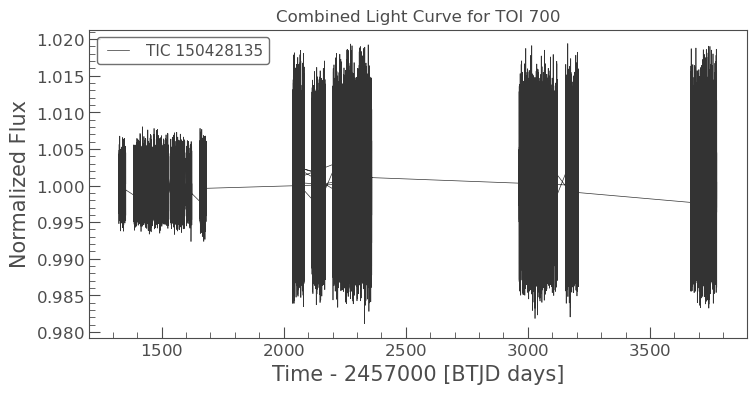

In [10]:
combined_lc.plot()
plt.title(f"Combined Light Curve for {TOI_id}")
plt.show()

In [11]:
# Extract useful data arrays
time = combined_lc.time.value
flux = combined_lc.flux.value
flux_err = combined_lc.flux_err.value
print(time)
print(flux)

[1325.29549502 1325.2968839  1325.29827278 ... 3773.18610283 3773.18749171
 3773.18888059]
[1.00081324 1.00001966 1.00057692 ... 1.001762   0.99997403 1.00044919]


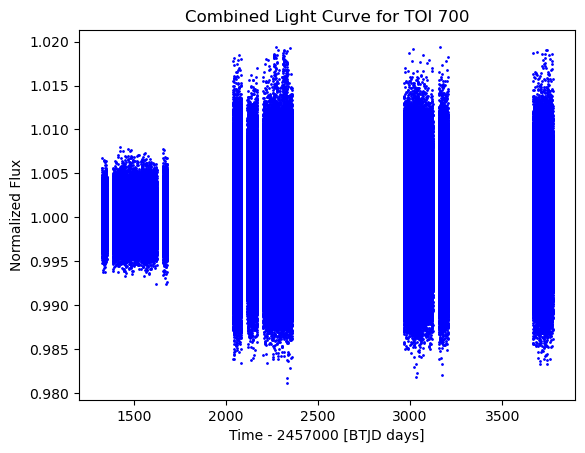

In [12]:
plt.scatter(time, flux, s=1, c='b')
plt.title(f'Combined Light Curve for {TOI_id}')
plt.xlabel('Time - 2457000 [BTJD days]')
plt.ylabel('Normalized Flux')
plt.show()

# BLS Runs

## BLS 1

`period` contains 227703 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


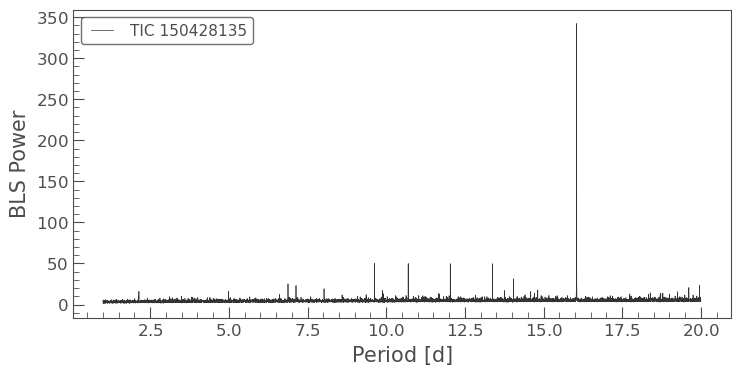

In [57]:
bls_1 = combined_lc.to_periodogram(method='bls', period=np.linspace(1, 20, 10000), frequency_factor=500)
bls_1.plot()
plt.show()


In [58]:
planet_1_period = bls_1.period_at_max_power
planet_1_dur = bls_1.duration_at_max_power
planet_1_t0 = bls_1.transit_time_at_max_power

print(f"Best candidate period: {planet_1_period.value:.5f} days")
print(f"Best candidate t0: {planet_1_t0.value:.5f} days")
print(f"Best candidate dur: {planet_1_dur.value:.5f} days")

Best candidate period: 16.05141 days
Best candidate t0: 1340.06550 days
Best candidate dur: 0.05000 days


In [66]:
import numpy as np
from scipy.signal import find_peaks

# 1. Access full power array
powers = bls_1.power.value
periods = bls_1.period.value
durations = bls_1.duration.value
t0s = bls_1.transit_time.value

# 2. Find all peaks in the BLS power spectrum
peaks, _ = find_peaks(powers)

# 3. Sort peaks by power (descending)
sorted_peaks = peaks[np.argsort(powers[peaks])[::-1]]

# 4. Get top 3 signal indices
top_indices = sorted_peaks[:7]

# 5. Extract their periods, durations, and t0s
top_periods = periods[top_indices]
top_durations = durations[top_indices]
top_t0s = t0s[top_indices]
top_powers = powers[top_indices]

# 6. Print results
for i in range(7):
    print(f"Signal {i+1}:")
    print(f"  Period:   {top_periods[i]:.5f} days")
    print(f"  T0:       {top_t0s[i]:.5f}")
    print(f"  Duration: {top_durations[i]:.5f} days")
    print(f"  Power:    {top_powers[i]:.5f}")
    print("-" * 30)


Signal 1:
  Period:   16.05141 days
  T0:       1340.06550
  Duration: 0.05000 days
  Power:    342.16790
------------------------------
Signal 2:
  Period:   9.63066 days
  T0:       1330.45550
  Duration: 0.05000 days
  Power:    50.07176
------------------------------
Signal 3:
  Period:   10.70047 days
  T0:       1329.43050
  Duration: 0.05000 days
  Power:    49.93555
------------------------------
Signal 4:
  Period:   12.03820 days
  T0:       1332.07550
  Duration: 0.05000 days
  Power:    49.69425
------------------------------
Signal 5:
  Period:   13.37594 days
  T0:       1326.71050
  Duration: 0.05000 days
  Power:    49.65368
------------------------------
Signal 6:
  Period:   14.04480 days
  T0:       1326.03550
  Duration: 0.05000 days
  Power:    31.33158
------------------------------
Signal 7:
  Period:   16.04570 days
  T0:       1340.67050
  Duration: 0.10000 days
  Power:    25.65176
------------------------------


In [94]:
# Create a cadence mask using the BLS parameters
planet_1_mask = bls_1.get_transit_mask(period=planet_1_period,
                                     transit_time=planet_1_t0,
                                     duration=planet_1_dur*1.5)

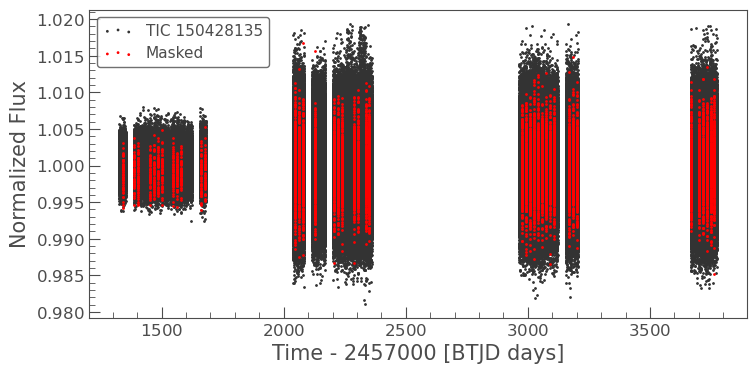

In [95]:
masked_lc_1 = combined_lc[~planet_1_mask]
ax = masked_lc_1.scatter();
combined_lc[planet_1_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [96]:
# Create a BLS model using the BLS parameters
planet_1_model = bls_1.get_transit_model(period=planet_1_period,
                                       transit_time=planet_1_t0,
                                       duration=planet_1_dur)


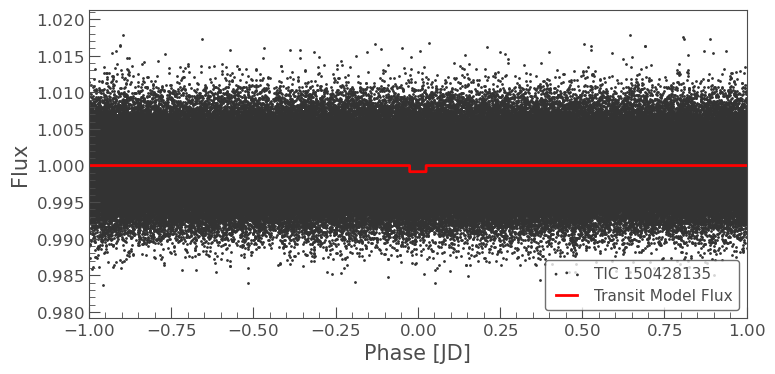

In [97]:
ax = combined_lc.fold(planet_1_period, planet_1_t0).scatter()
planet_1_model.fold(planet_1_period, planet_1_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1)
plt.show()

## BLS 2

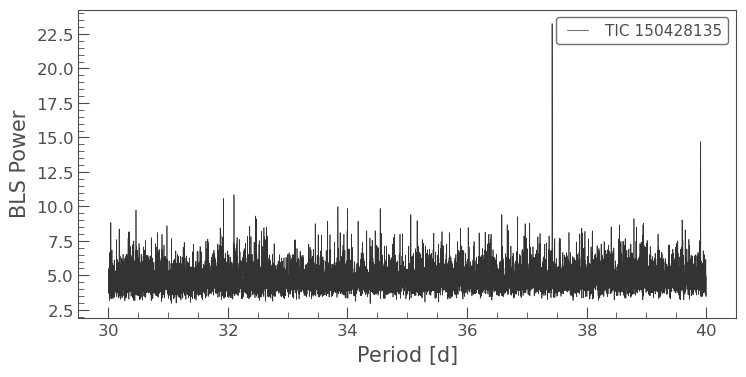

In [100]:
period = np.linspace(30, 40, 10000)
bls_2 = masked_lc_1.to_periodogram('bls', period=period, frequency_factor=500)
bls_2.plot()
plt.show()

In [101]:
planet_2_period = bls_2.period_at_max_power
planet_2_t0 = bls_2.transit_time_at_max_power
planet_2_dur = bls_2.duration_at_max_power

print(f"Best candidate period 2: {planet_2_period.value:.5f} days")
print(f"Best candidate t0 2: {planet_2_t0.value:.5f} days")

Best candidate period 2: 37.42374 days
Best candidate t0 2: 1330.48050 days


In [102]:
# ax = masked_lc_1.fold(planet_2_period, planet_2_t0).scatter()
# masked_lc_1.fold(planet_2_period, planet_2_t0).bin(.1).plot(ax=ax, c='r', lw=2,
#                                                           label='Binned Flux')
# ax.set_xlim(-5, 5)
# plt.show()

In [103]:
planet_2_mask = bls_2.get_transit_mask(period=planet_2_period,
                                     transit_time=planet_2_t0,
                                     duration=planet_2_dur*1.5)

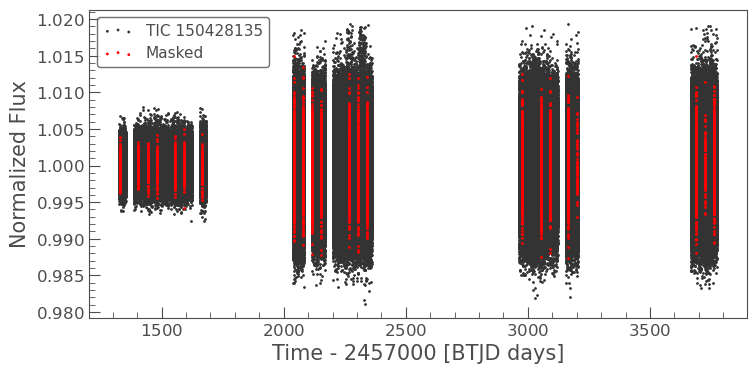

In [104]:
masked_lc_2 = masked_lc_1[~planet_2_mask]
ax = masked_lc_2.scatter();
masked_lc_1[planet_2_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [105]:
planet_2_model = bls_2.get_transit_model(period=planet_2_period,
                                       transit_time=planet_2_t0,
                                       duration=planet_2_dur)

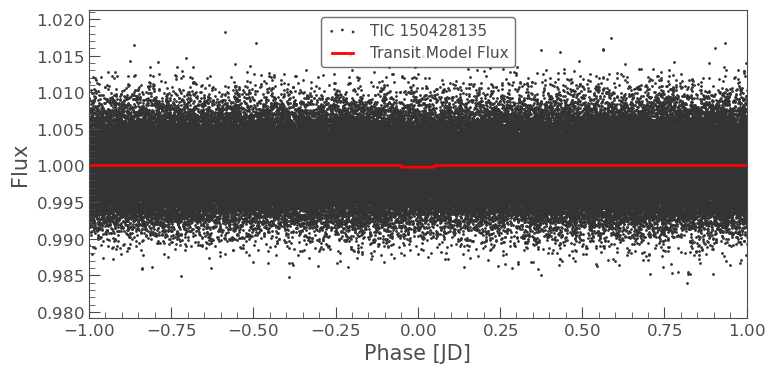

In [106]:
ax = combined_lc.fold(planet_2_period, planet_2_t0).scatter()
planet_2_model.fold(planet_2_period, planet_2_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1)
plt.show()

## BLS 3

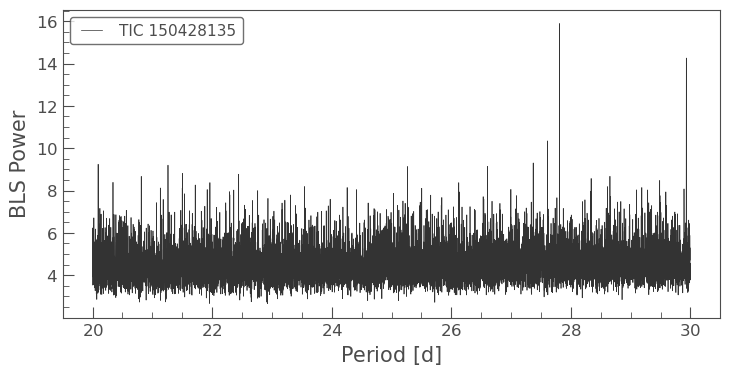

In [107]:
period = np.linspace(20, 30, 10000)
bls_3 = masked_lc_2.to_periodogram('bls', period=period, frequency_factor=500)
bls_3.plot()
plt.show()

In [108]:
planet_3_period = bls_3.period_at_max_power
planet_3_t0 = bls_3.transit_time_at_max_power
planet_3_dur = bls_3.duration_at_max_power

print(f"Best candidate period 3: {planet_3_period.value:.5f} days")
print(f"Best candidate t0 3: {planet_3_t0.value:.5f} days")

Best candidate period 3: 27.80978 days
Best candidate t0 3: 1353.00050 days


In [109]:
planet_3_mask = bls_3.get_transit_mask(period=planet_3_period,
                                     transit_time=planet_3_t0,
                                     duration=planet_3_dur*1.5)

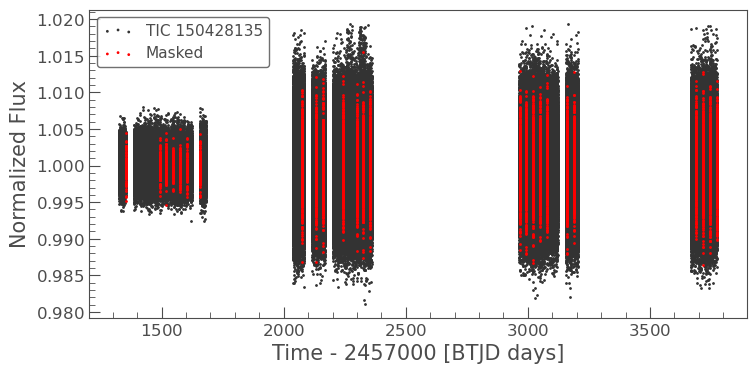

In [110]:
masked_lc_3 = masked_lc_2[~planet_3_mask]
ax = masked_lc_3.scatter();
masked_lc_2[planet_3_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [111]:
planet_3_model = bls_3.get_transit_model(period=planet_3_period,
                                       transit_time=planet_3_t0,
                                       duration=planet_3_dur)

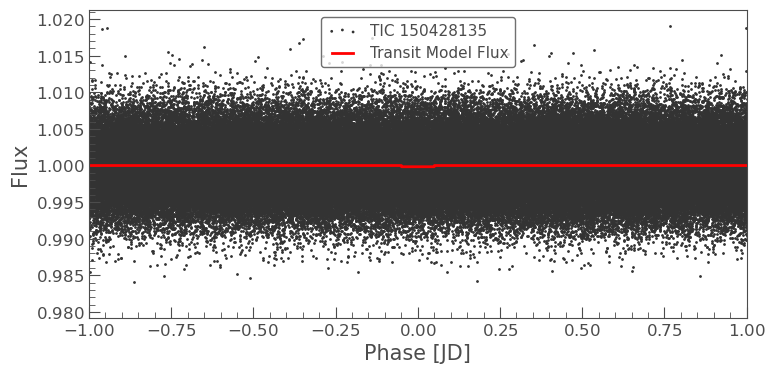

In [112]:
ax = combined_lc.fold(planet_3_period, planet_3_t0).scatter()
planet_3_model.fold(planet_3_period, planet_3_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1)
plt.show()

## Transit models

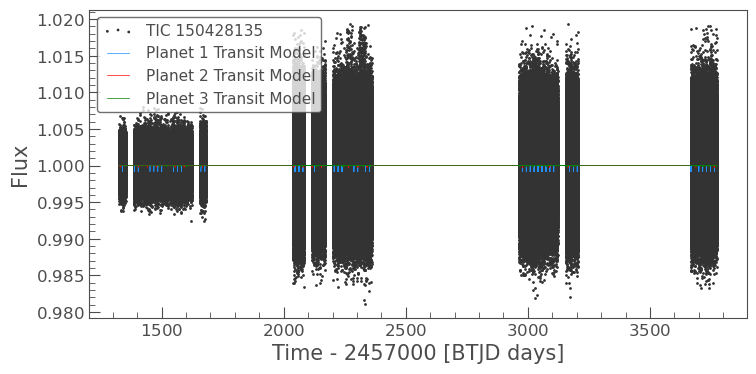

In [113]:
ax = combined_lc.scatter();
planet_1_model.plot(ax=ax, c='dodgerblue', label='Planet 1 Transit Model');
planet_2_model.plot(ax=ax, c='r', label='Planet 2 Transit Model');
planet_3_model.plot(ax=ax, c='g', label='Planet 3 Transit Model');
# planet_4_model.plot(ax=ax, c='purple', label='Planet 4 Transit Model');
# planet_5_model.plot(ax=ax, c='orange', label='Planet 5? Transit Model');
# planet_6_model.plot(ax=ax, c='pink', label='Planet 6 Transit Model');

# plt.xlim(1340,1345)
# plt.ylim(0.998,1.002)
plt.show()

## Finding transit guess times based on models 

In [114]:
from scipy.signal import find_peaks

# Find all local minima (i.e., transit dips)
peaks_1, _ = find_peaks(-planet_1_model.flux.value, prominence=1e-5)
transit_times_1 = planet_1_model.time.value[peaks_1]
fluxes_1 = planet_1_model.flux.value[peaks_1]

print("Planet 1 transit dip times and depths:")
# for t, f in zip(transit_times_1, fluxes_1):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_1)

Planet 1 transit dip times and depths:
[1340.0648903  1388.21903071 1404.27045405 1452.42619567 1468.47627882
 1484.52774634 1500.57920045 1548.73344841 1564.78482022 1580.8361658
 1661.09271345 1677.14402264 2206.84139733 2222.89262426 2126.58435361
 2046.32729061 2062.37884531 2078.42973011 2126.58400639 2046.32717487
 2206.84128159 2222.89274    2062.37849809 2078.42984585 2335.25206921
 2351.30291598 2287.09851788 2303.14987435 2238.94429856 2238.94418281
 2287.09701326 2303.14975861 2335.25241643 2351.30372616 3185.97666981
 3202.02851371 3169.92553779 3105.72004203 3041.51456119 3057.56520142
 3073.61697975 3089.66897673 2993.36022551 3009.41161688 2977.3088055
 3025.46321334 3025.4619402  2993.35918384 3009.41057522 3041.51328805
 3057.56462272 3073.61593809 3089.66862951 2977.30776383 3105.71992629
 3169.92519057 3185.97655407 3202.027935   3667.51943835 3667.51793371
 3731.72516767 3747.77631727 3763.82721754 3699.62211169 3715.67330403
 3731.72366304 3699.62083854 3715.672262

In [115]:
# Find all local minima (i.e., transit dips)
peaks_2, _ = find_peaks(-planet_2_model.flux.value, prominence=1e-5)
transit_times_2 = planet_2_model.time.value[peaks_2]
fluxes_2 = planet_2_model.flux.value[peaks_2]

print("Planet 2 transit dip times and depths:")
# for t, f in zip(transit_times_2, fluxes_2):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_2)

Planet 2 transit dip times and depths:
[1330.48020577 1405.32740175 1442.75115489 1480.1749431  1555.02232917
 1592.44723749 1667.29406522 2153.80295569 2116.37808531 2041.53240847
 2078.9551923  2116.37982143 2041.53136681 2153.80214551 2078.95484508
 2340.92102535 2303.49848409 2266.06749792 2266.06645625 2303.49697947
 2340.92044665 3164.24407289 3051.97262727 3089.39675617 2977.12523975
 3051.9715856  3089.39502007 2977.12442956 3164.24326271 3688.17646493
 3688.1749603  3763.02420817 3763.02362946]


In [116]:
# Find all local minima (i.e., transit dips)
peaks_3, _ = find_peaks(-planet_3_model.flux.value, prominence=1e-5)
transit_times_3 = planet_3_model.time.value[peaks_3]
fluxes_3 = planet_3_model.flux.value[peaks_3]

print("Planet 3 transit dip times and depths:")
# for t, f in zip(transit_times_2, fluxes_2):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_3)

Planet 3 transit dip times and depths:
[1352.99958662 1492.04860403 1519.85841822 1547.66816987 1575.47785013
 1603.29024543 1658.90800103 2159.48376184 2131.67464213 2076.05496381
 2131.67429491 2159.48410906 2076.05345918 2354.15243789 2298.53368412
 2326.34840821 2242.91375403 2242.9122494  2298.53171653 2326.34829247
 2354.15232215 3188.4470375  3160.63668126 3049.39787318 3077.20654228
 2993.77758689 2965.96780367 3021.58683772 3021.58695346 2993.77723967
 3049.39660004 3077.20619506 2965.96745644 3160.63494515 3188.44738473
 3689.02160433 3689.01940526 3744.6418351  3772.45173226 3716.83233039
 3744.64033048 3716.83059429 3772.45138504]


/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


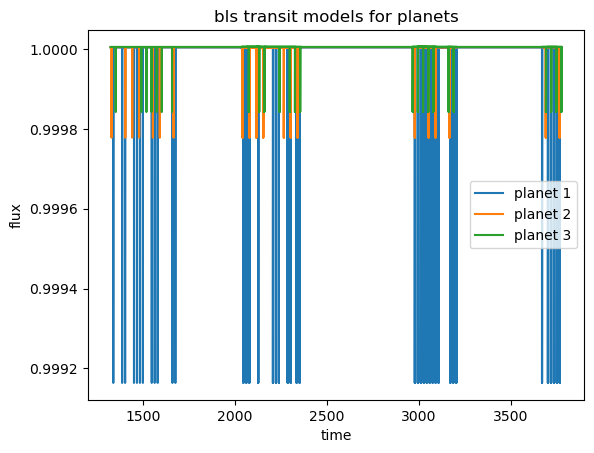

In [117]:
plt.plot(planet_1_model.time.value, planet_1_model.flux.value, label='planet 1')
plt.plot(planet_2_model.time.value, planet_2_model.flux.value, label='planet 2')
plt.plot(planet_3_model.time.value, planet_3_model.flux.value, label='planet 3')
# plt.plot(planet_4_model.time.value, planet_4_model.flux.value, label='planet 4')
# plt.plot(planet_5_model.time.value, planet_5_model.flux.value, label='planet 5?')
# plt.plot(planet_6_model.time.value, planet_6_model.flux.value, label='planet 6?')

# plt.xlim(1335,1345)
# plt.xlim(1330,1350)
# plt.xlim(2100,2200)
# plt.xlim(1377,1380)
plt.title('bls transit models for planets')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()

# Fit Transit Times

In [118]:
from scipy.optimize import minimize
from scipy.optimize import root_scalar
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

## Definitions

In [119]:
def omc(obs_time, t_num, p, tc):
    calc_time = tc + (t_num* p)
    omc = obs_time - calc_time
    return omc#*24 #days to hours

### Find the intersection points
def intersection_func(t,tc1,chi_sq, err_threshold): 
    return np.interp(t, tc1, chi_sq) - err_threshold

In [120]:

def plot_chi_sq(time, flux, flux_err, tc, tc_guess, per, rp, b, T14, u1, u2):
    '''
    args:
        time: array of times from lightcurve
        flux: array of fluxes from lightcurve
        flux_err: array of flux errors from lightcurve
        tc: range of values around the guess time
        tc_guess: guess transit time
        per: period of planet
        rp: radius ratio (planet/star)
        b: impact parameter
        T14: transit duration
        u1, u2: limb darkening coefficients 
    '''
    ### plot X^2 vs tc for each guess
    for j in range(len(tc)):
        tc1 = tc[j]
        chi_sq = np.zeros(len(tc1))
        chi_sq_lc = np.zeros(len(tc1))
        for i in range(len(tc1)):
            t0_1 = 	tc1[i]
            theta_initial = [t0_1, per, rp, b, T14, u1, u2]
            
            ### initialize params
            params = batman.TransitParams()
            # params.t0, params.per, params.rp,params.b, params.T14, q1, q2 = theta_initial
            # params.u = [2*np.sqrt(q1)*q2, np.sqrt(q1)*(1-2*q2)]  # Limb darkening coefficients
            params.t0, params.per, params.rp,params.b, params.T14, u1, u2 = theta_initial
            params.u = [u1, u2] 
            params.limb_dark = 'quadratic'
            
            ### mask data - extract relevant photometry
            start = tc_guess[j] - ttv_hour
            end = tc_guess[j] + ttv_hour
            mask = (time > (start)) & (time < (end))
            
            transit_model = batman.TransitModel(params, time[mask])
                
            # Generate model light curve
            model_flux = transit_model.light_curve(params)
            
            # Calculate chi-squared value
            sigma2 = flux_err[mask] 
            chi_squared = np.sum(((flux[mask] - model_flux) / sigma2)**2)
            chi_sq[i] = (chi_squared)
    
        ### masked
        min_chi_time = tc1[np.argmin(chi_sq)]
        min_chi = chi_sq.min()
    
        tc_chi[j] = min_chi_time
        # idx = transit_num[j]
        ttv[j] = min_chi_time - tc_guess[j]
    
        chi_mask = (chi_sq <= min_chi + 3)
        fit_mask = (chi_sq <= min_chi + 1)
    
        ### fit parabola to the chisq
        p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)  
    
        ### Extract the coefficients   y = ax^2 + bx + c
        a_chi_sq, b_chi_sq, c_chi_sq = p_chi_sq
        
        ### Find the minimum of the parabola xmin = -b/2a from taking derivative=0
        tc_best_fit = -b_chi_sq / (2 * a_chi_sq)
        
        ### Calculate the minimum chi-squared value
        chi_sq_min = a_chi_sq * tc_best_fit**2 + b_chi_sq * tc_best_fit + c_chi_sq
        tc_chi_parabola[j] = tc_best_fit
    
        ### Calculate the parabola best fit 
        p_1 = a_chi_sq*tc1**2 + b_chi_sq*tc1 + c_chi_sq
    
        ### calculate ttv from parabola fit 
        ttv_p[j] = tc_best_fit - tc_guess[j]
    
        ### delta chisq = 1 gives errors
        err_threshold = min_chi + 1 # using chisq discrete minimum
        err_threshold_p = chi_sq_min + 1 # using minimum of parabola
      
        # # Find the intersection using root_scalar
        # intersections = []
        # for k in range(len(tc1) - 1):
        #     if (chi_sq[k] - err_threshold) * (chi_sq[k + 1] - err_threshold) < 0:
        #         sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]], args=(tc1, chi_sq, err_threshold))
        #         if sol.converged:
        #             intersections.append((sol.root - min_chi_time))
        # errors.append(intersections)
    
        # intersections_p = []
        # for k in range(len(tc1) - 1):
        #     if (p_1[k] - err_threshold_p) * (p_1[k + 1] - err_threshold_p) < 0:
        #         sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]], args=(tc1, chi_sq, err_threshold))
        #         if sol.converged:
        #             intersections_p.append((sol.root - tc_best_fit))
        # errors_p.append(intersections_p)
    
        # plt.plot(tc1[chi_mask], chi_sq[chi_mask],label='chisq')
        # plt.plot(tc1[chi_mask], p_1[chi_mask],label='chisq parabola', color='orange')
        # plt.axvline(x=tc_guess[j], color='r', linestyle='--', label='Bls Guess')
        # plt.axvline(x=min_chi_time, linestyle='--', label='Chisq min')
        # plt.axvline(x=tc1[np.argmin(p_1)], color='orange', linestyle='--', label='Chisq min parabola')
    
        # # for inter in intersections:
        # #     plt.axvline(x=inter, color='blue', linestyle='--')
        # plt.axhline(y=err_threshold, color='green', linestyle='--', label='Error Threshold')
        # plt.title(f'Transit {j+1}: Planet b')
        # plt.xlabel('tc')
        # plt.ylabel('X^2')
        # plt.legend()
        # plt.show()

    return tc_chi, ttv

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import batman

def plot_transits(transit_times, per, rp, b, T14, u1, u2):
    cols = 3
    rows = int(np.ceil(len(transit_times) / cols))
    
    fig = plt.figure(figsize=(14, rows * 2.8))
    outer = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.5)
    
    for i, t0 in enumerate(transit_times):
        row = i // cols
        col = i % cols
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col],
                                                 height_ratios=[3, 1], hspace=0.0)  # Panels touch
    
        t_min = t0 - buffer
        t_max = t0 + buffer
        mask = (time >= t_min) & (time <= t_max)
        time_rel = time[mask] - t0  # Time relative to Tc
    
        # Transit model setup
        theta_initial = [t0, per, rp, b, T14, u1, u2]
        params = batman.TransitParams()
        params.t0, params.per, params.rp, params.b, params.T14, u1, u2 = theta_initial
        params.u = [u1, u2]
        params.limb_dark = 'quadratic'
    
        m = batman.TransitModel(params, time[mask])
        model_flux = m.light_curve(params)
        residuals = flux[mask] - model_flux

        # Calculate binned points
        num_bins = 20  # Adjust number of bins as needed
        bins = np.linspace(-buffer, buffer, num_bins + 1)
        digitized = np.digitize(time_rel, bins)
        bin_means = [flux[mask][digitized == i].mean() for i in range(1, len(bins))]
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
    
    
        # Top panel: model + data
        ax1 = fig.add_subplot(inner[0])
        ax1.scatter(time_rel, flux[mask], s=5, label='Data')
        ax1.scatter(bin_centers, bin_means, c='orange', marker='o', label='Binned Data')
        ax1.plot(time_rel, model_flux, color='red', label='Model')
        ax1.axvline(0, color='green', linestyle='--', label='Tc')
        ax1.set_xlim(-buffer, buffer)
        ax1.set_title(f'Tc = {round(t0, 3)} (BJD-{TESS_offset})')
        ax1.grid(True)
        ax1.tick_params(labelbottom=False)
    
        # Bottom panel: residuals
        ax2 = fig.add_subplot(inner[1], sharex=ax1)
        ax2.scatter(time_rel, residuals, s=5)
        ax2.scatter(bin_centers, [0] * len(bin_centers), c='orange', marker='o', label='Binned Data')
        ax2.axhline(0, color='red', linestyle='--', linewidth=1)
        ax2.set_xlim(-buffer, buffer)
        ax2.set_xlabel("Time from Tc [days]")
        ax2.grid(True)
    
        # Y-axis labels for first column only
        if col == 0:
            ax1.set_ylabel("Flux")
            ax2.set_ylabel("Residuals")
        else:
            ax1.set_ylabel("")
            ax1.tick_params(labelleft=False)
            ax2.set_ylabel("")
            ax2.tick_params(labelleft=False)
    
        # Custom ticks
        ticks = np.round(np.linspace(-buffer, buffer, 4), 2)
        ax2.set_xticks(ticks)
    
    plt.show()


In [150]:
### stellar params
# r1 and r2 in rodriguez et al 2020
u1 = 0.20
u2 = 0.48
print(u1)
print(u2)

0.2
0.48


## Planet 1

In [151]:
### Planet params (from exoplanet archive Gilbert et al 2023)
# planet b
per_1=  16.051137
rp_1= 0.0565
b_1=  0.899
T14_1= 0.0593 #* 0.0416667  # convert to days from hours 


In [152]:
tc_guess_1 = transit_times_1
### get tc ranges for fit
tc_1 = []
for i in range(len(tc_guess_1)):
    start = tc_guess_1[i] - ttv_hour
    end = tc_guess_1[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_1.append(t)

In [153]:
### initialize arrays
tc_chi = np.zeros(len(tc_1))
tc_chi_parabola = np.zeros(len(tc_1))
ttv = np.zeros(len(tc_1))
ttv_p = np.zeros(len(tc_1))
errors = []
errors_p = []

In [154]:
tc_chi_1, ttv_1 = plot_chi_sq(time, flux, flux_err, tc_1, tc_guess_1, per_1, rp_1, b_1, T14_1, u1, u2)

In [155]:
print(tc_chi_1)

[1340.08974851 1388.24155325 1404.29314342 1452.44287903 1468.49713303
 1484.54960155 1500.59955416 1548.75146644 1564.80317192 1580.85435066
 1661.10973048 1677.16437634 2206.84606867 2222.9007991  2126.59503096
 2046.33780113 2062.38768749 2078.44290997 2126.59501741 2046.33768539
 2206.84611977 2222.90074801 2062.38767393 2078.44285887 2335.25807522
 2351.30475115 2287.10135406 2303.15604719 2238.95447541 2238.95435967
 2287.10135093 2303.15593145 2335.25808877 2351.30472716 3185.96399046
 3202.01483335 3169.91452677 3105.70702901 3041.50505168 3057.55485774
 3073.61013957 3089.66146922 2993.34721248 3009.40244103 2977.30163166
 3025.45537216 3025.45543369 2993.34717182 3009.40240037 3041.5051132
 3057.55477953 3073.61009891 3089.66145566 2977.30159099 3105.70691327
 3169.91451322 3185.96404155 3202.01492198 3667.49458014 3667.494577
 3731.70014262 3747.75579674 3763.80235932 3699.60192482 3715.65378449
 3731.7001395  3699.6018195  3715.65374383 3747.75585826 3763.80238331]


In [156]:
# Transit windows
buffer = 1.5 * T14_1
transit_times_1 = tc_chi_1

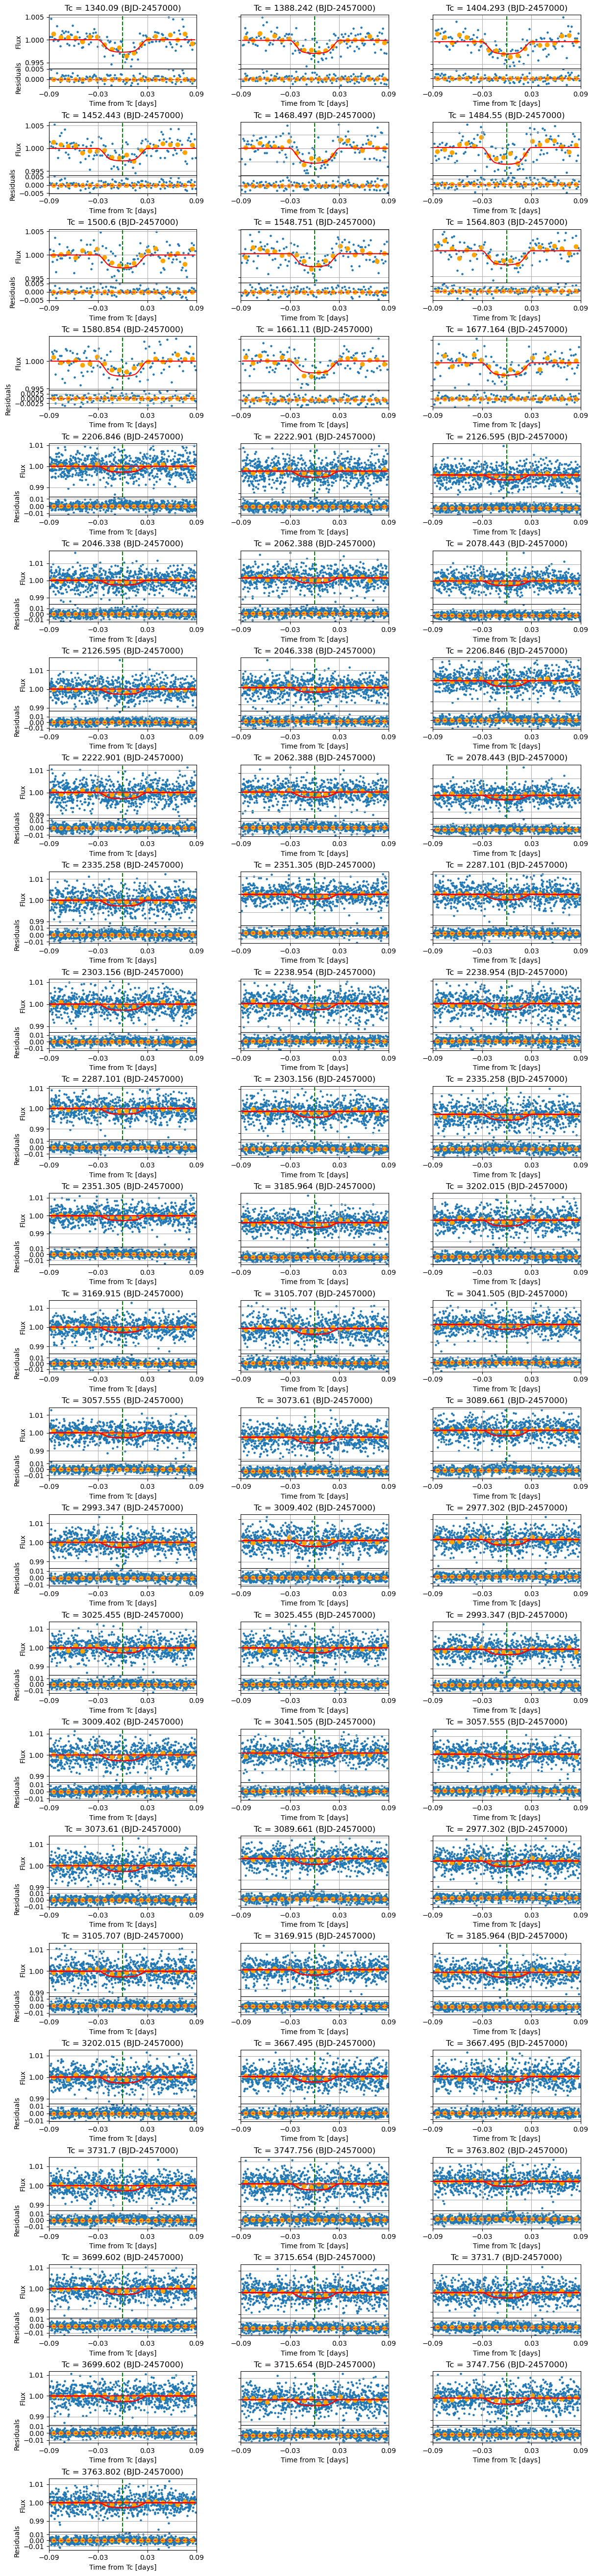

In [157]:
plot_transits(transit_times_1, per_1, rp_1, b_1, T14_1, u1, u2)

## Planet 2

In [160]:
### Planet params (from barros et al 2022)
# planet b
per_2=  37.42396
rp_2=  0.02339
b_2=  0.29
T14_2= 0.1381 # * 0.0416667  # convert to days from hours (from Gunther et al 2019)


In [161]:
tc_guess_2 = transit_times_2
### get tc ranges for fit
tc_2 = []
for i in range(len(tc_guess_2)):
    start = tc_guess_2[i] - ttv_hour
    end = tc_guess_2[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_2.append(t)

In [162]:
### initialize arrays
tc_chi = np.zeros(len(tc_2))
tc_chi_parabola = np.zeros(len(tc_2))
ttv = np.zeros(len(tc_2))
ttv_p = np.zeros(len(tc_2))
errors = []
errors_p = []

In [163]:
tc_chi_2, ttv_2 = plot_chi_sq(time, flux, flux_err, tc_2, tc_guess_2, per_2, rp_2, b_2, T14_2, u1, u2)

In [164]:
print(tc_chi_2)

[1330.47586809 1405.32256357 1442.71178216 1480.16026174 1555.02166183
 1592.45991684 1667.30023806 2153.78593866 2116.38609332 2041.53657931
 2078.94401445 2116.38599427 2041.53653865 2153.78596264 2078.94416773
 2340.91485251 2303.5014871  2266.12121835 2266.12117768 2303.50148398
 2340.91477431 3164.23523071 3051.96194991 3089.39675617 2976.98126232
 3051.96190925 3089.39502007 2976.98111947 3164.2352547  3688.16812325
 3688.16812012 3763.01486548 3763.01478728]


In [165]:
# Transit windows
buffer = 1.5 * T14_2
transit_times_2 = tc_chi_2

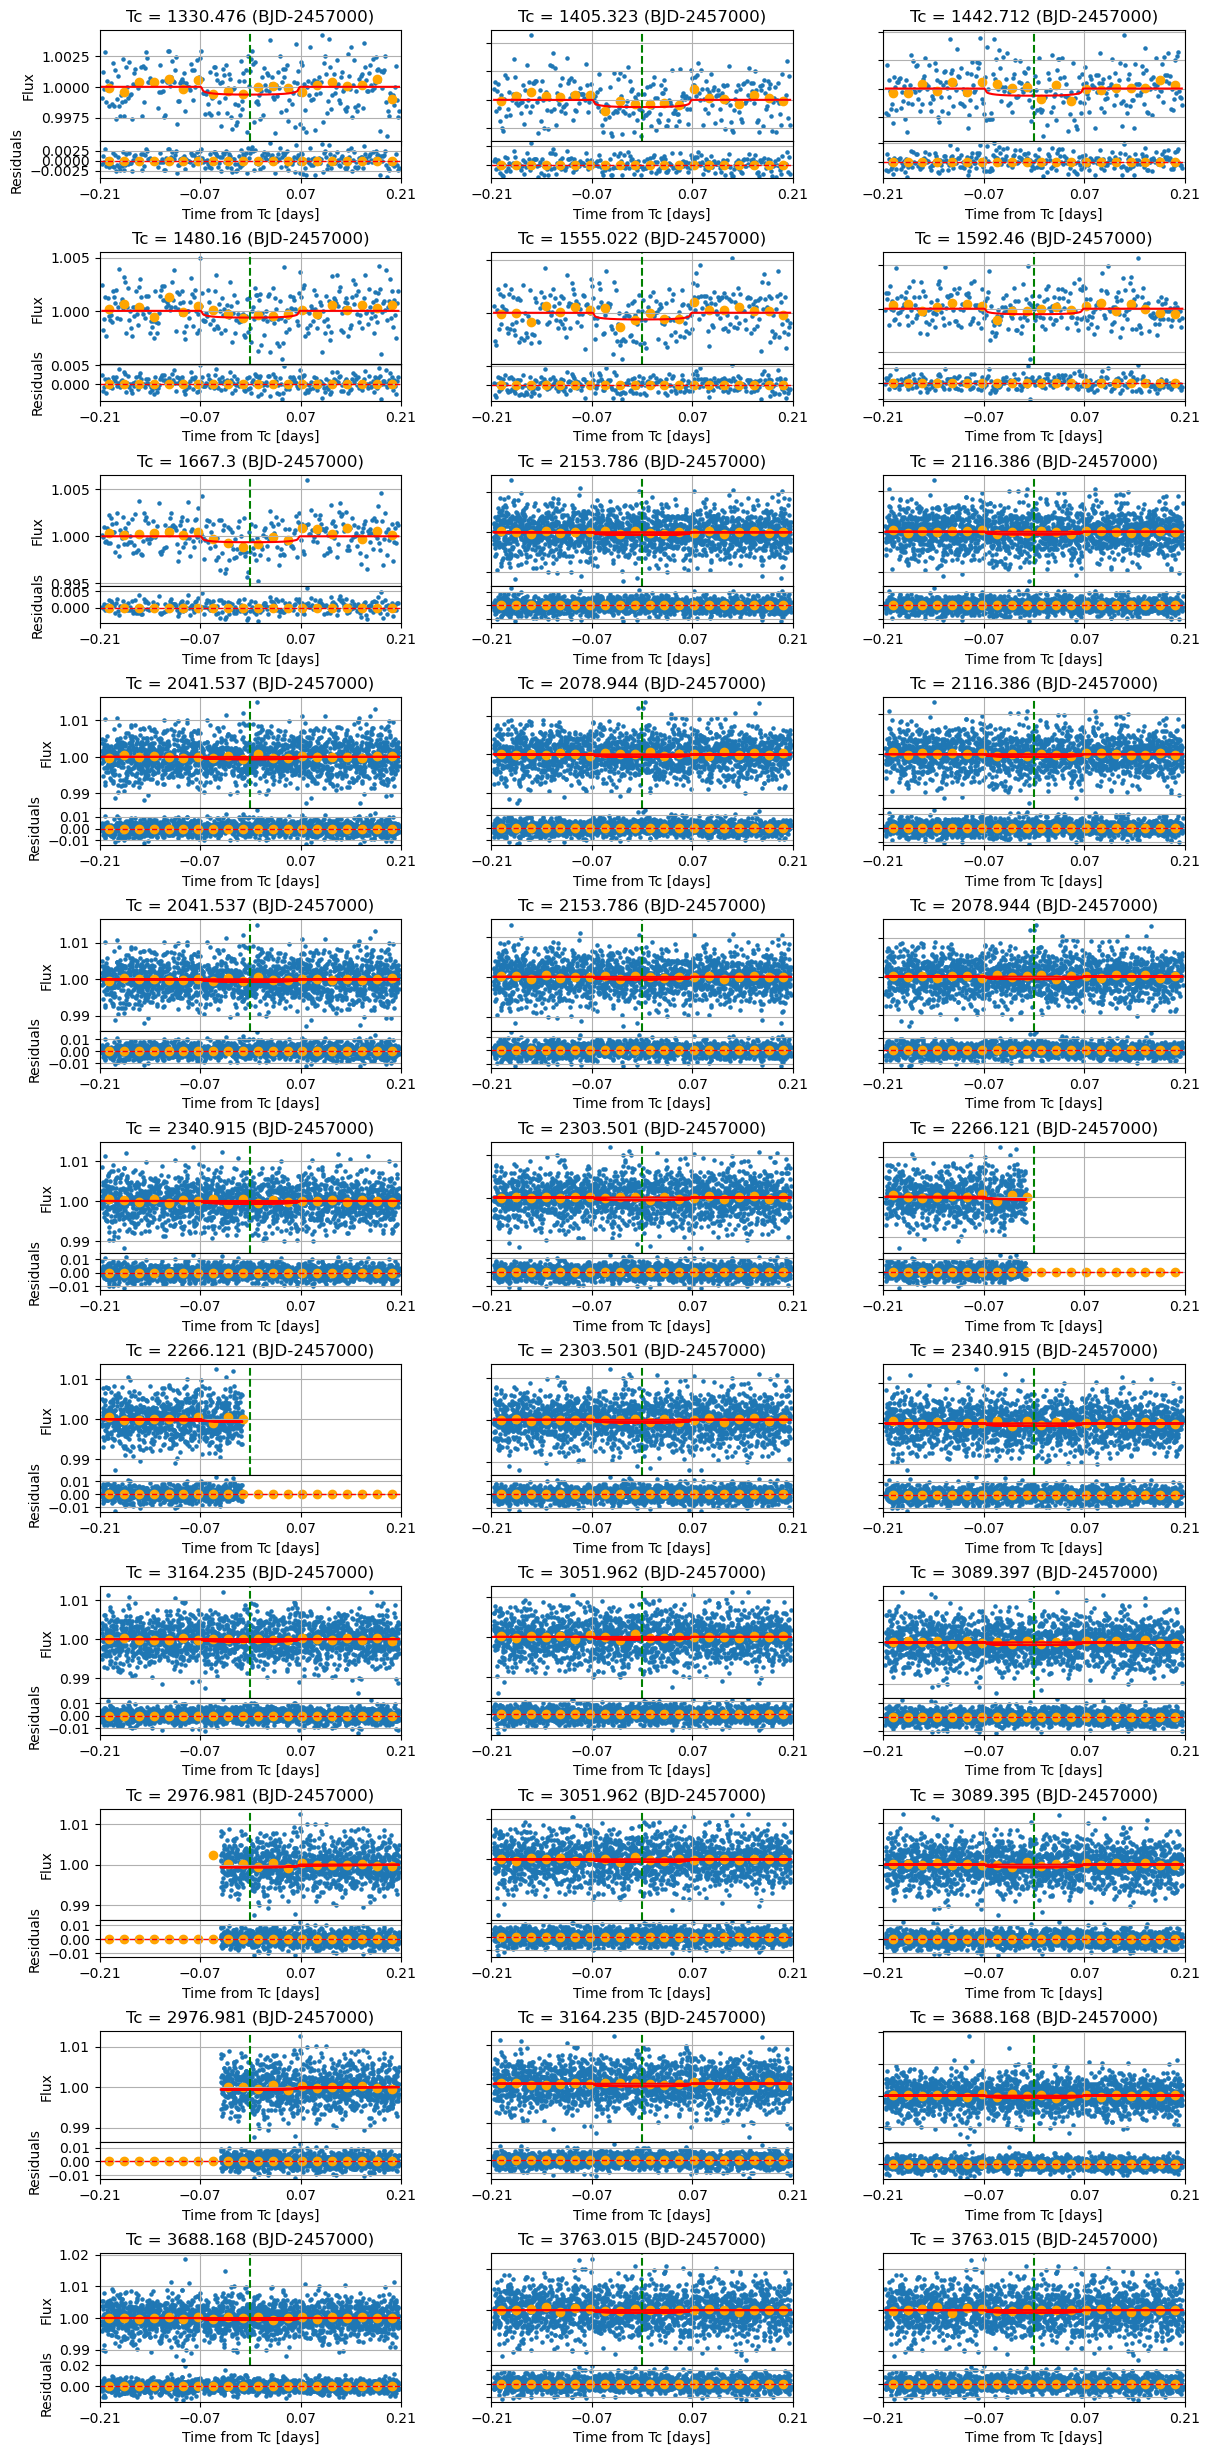

In [166]:
plot_transits(transit_times_2, per_2, rp_2, b_2, T14_2, u1, u2)

## Planet 3

In [167]:
### Planet params (from barros et al 2022)
# planet b
per_3=  27.80978
rp_3=   0.0208
b_3=  0.47
T14_3= 0.1157 # * 0.0416667  # convert to days from hours (from Gunther et al 2019)


In [168]:
tc_guess_3 = transit_times_3
### get tc ranges for fit
tc_3 = []
for i in range(len(tc_guess_3)):
    start = tc_guess_3[i] - ttv_hour
    end = tc_guess_3[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_3.append(t)

In [169]:
### initialize arrays
tc_chi = np.zeros(len(tc_3))
tc_chi_parabola = np.zeros(len(tc_3))
ttv = np.zeros(len(tc_3))
ttv_p = np.zeros(len(tc_3))
errors = []
errors_p = []

In [170]:
tc_chi_3, ttv_3 = plot_chi_sq(time, flux, flux_err, tc_3, tc_guess_3, per_3, rp_3, b_3, T14_3, u1, u2)

In [171]:
print(tc_chi_3)

[1353.00976348 1492.0132353  1519.83756401 1547.68585423 1575.53924491
 1603.30759613 1658.88230865 2159.477589   2131.6749758  2076.05629848
 2131.67496224 2159.47743572 2076.05629535 2354.14476354 2298.58540254
 2326.329556   2242.90557919 2242.90557605 2298.58527012 2326.32944026
 2354.14481463 3188.37846888 3160.47301746 3049.5541963  3077.20654228
 2993.73370964 2965.96012932 3021.73648749 3021.7364364  2993.73369609
 3049.55425783 3077.20619506 2965.96011576 3160.47294969 3188.37848244
 3689.03111385 3689.03108361 3744.62648641 3772.46474528 3716.81931737
 3744.62648328 3716.8192496  3772.46473173]


In [172]:
# Transit windows
buffer = 1.5 * T14_3
transit_times_3 = tc_chi_3

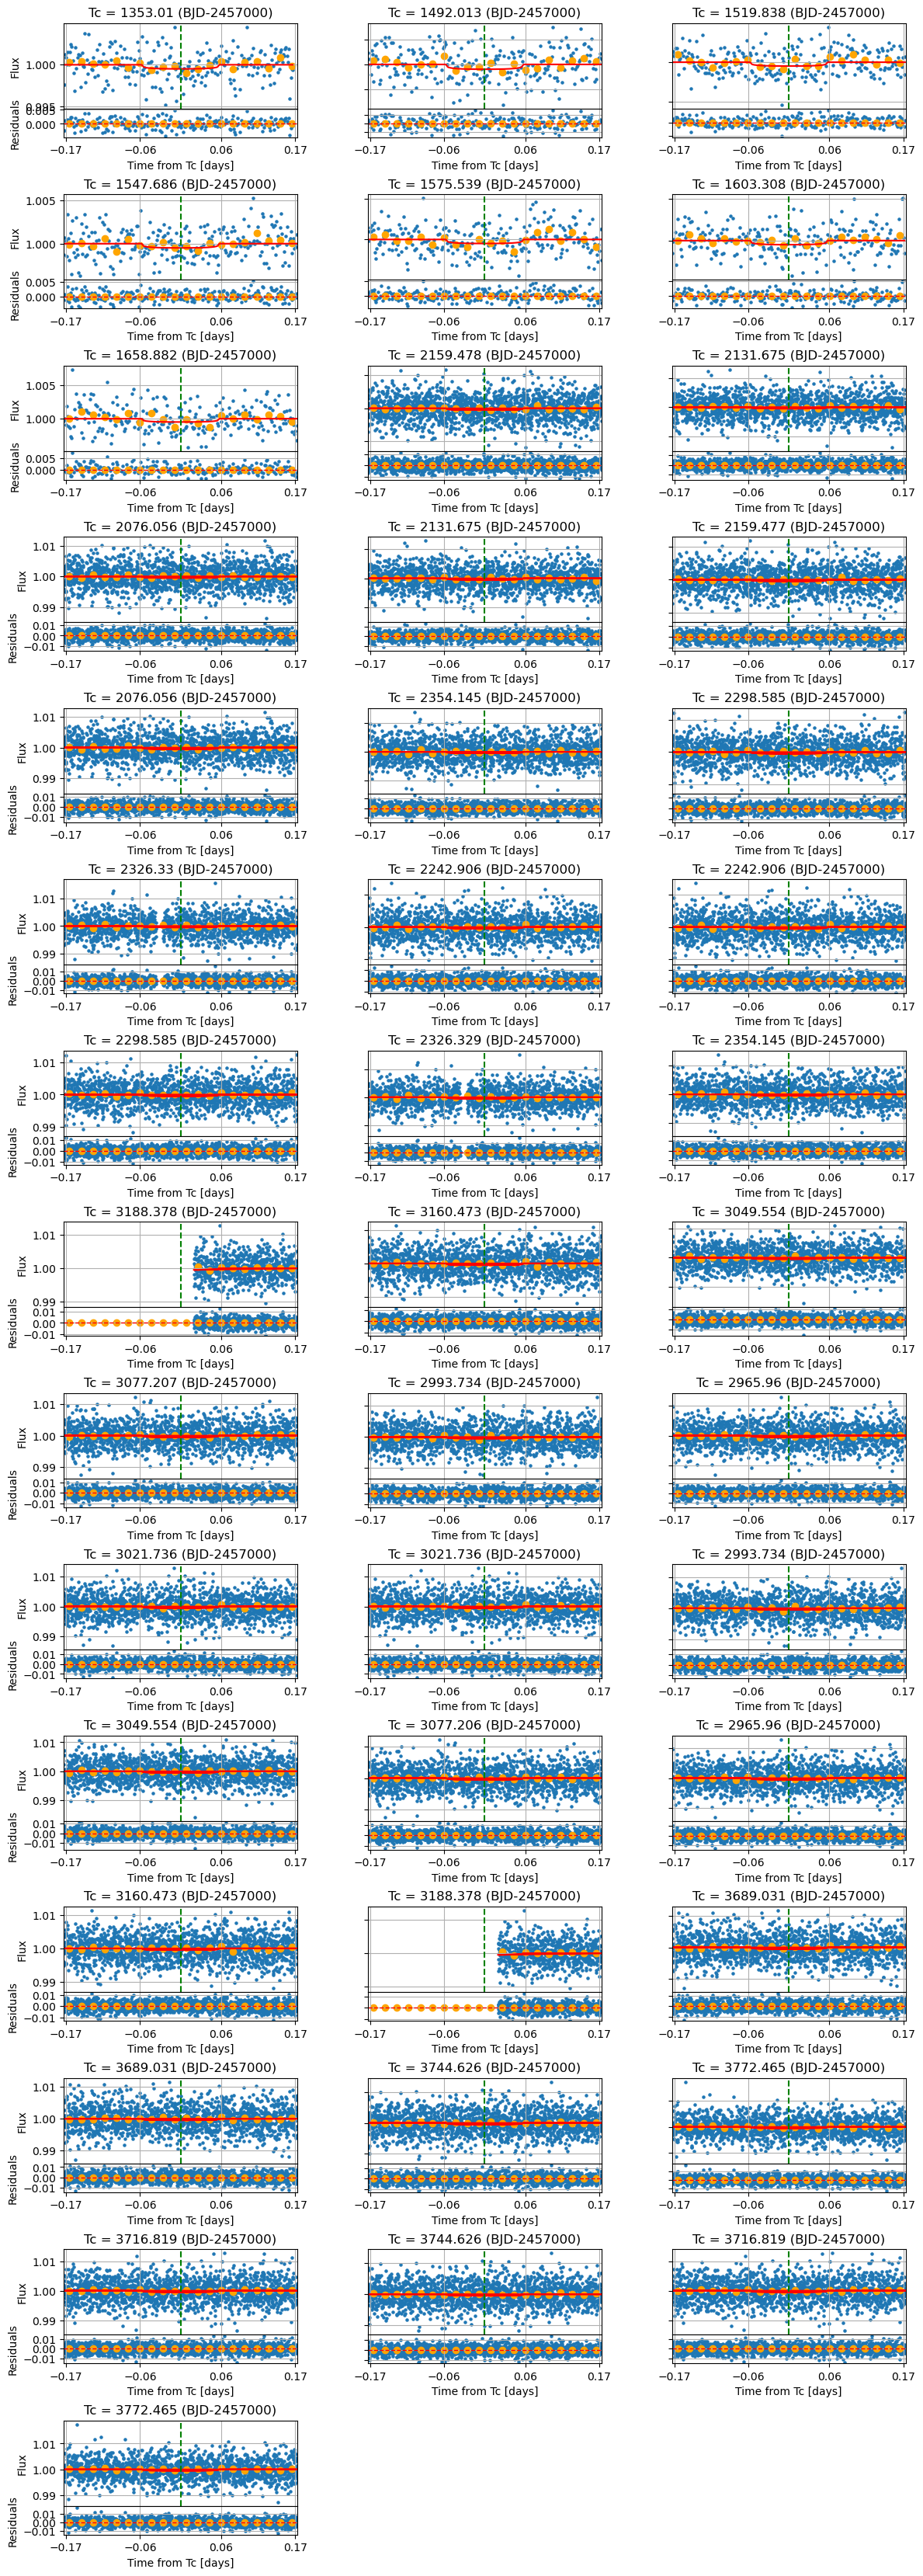

In [173]:
plot_transits(transit_times_3, per_3, rp_3, b_3, T14_3, u1, u2)

# O-C

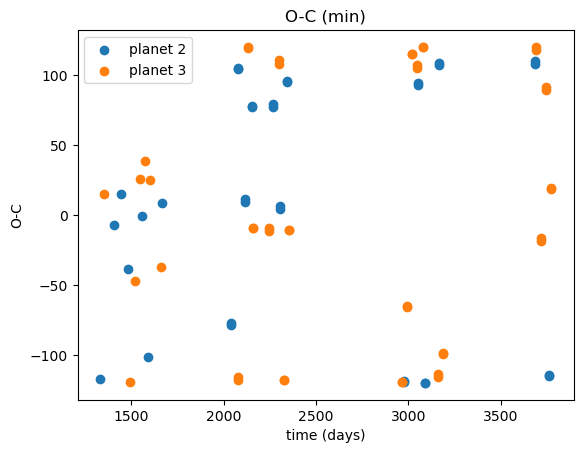

In [144]:
# TTV
plt.scatter(tc_chi_2, ttv_2*(24*60), label='planet 2')
plt.scatter(tc_chi_3, ttv_3*(24*60), label='planet 3')
plt.title('O-C (min)')
plt.xlabel('time (days)')
plt.ylabel('O-C')
plt.legend()
plt.show()

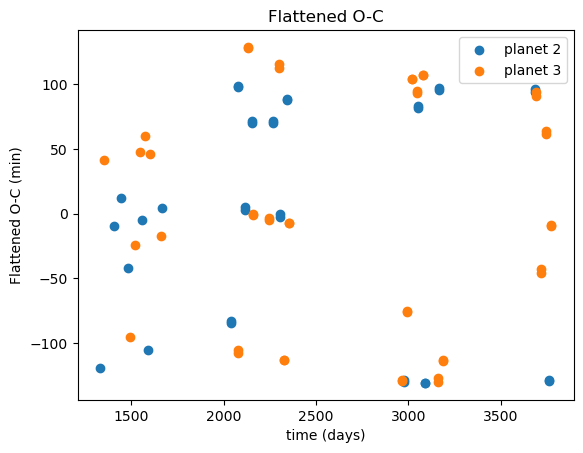

In [145]:
# Fit a linear function to the TTV data
coeffs_1 = np.polyfit(tc_chi_2, ttv_2*(24*60), 1)
linear_fit_1 = np.polyval(coeffs_1, tc_chi_2)

coeffs_2 = np.polyfit(tc_chi_3, ttv_3*(24*60), 1)
linear_fit_2 = np.polyval(coeffs_2, tc_chi_3)

# Subtract the linear fit from the TTV data
ttv_2_detrended = ttv_2*(24*60) - linear_fit_1
ttv_3_detrended = ttv_3*(24*60) - linear_fit_2

# Plot the detrended data
plt.scatter(tc_chi_2, ttv_2_detrended, label='planet 2')
plt.scatter(tc_chi_3, ttv_3_detrended, label='planet 3')
plt.title('Flattened O-C')
plt.xlabel('time (days)')
plt.ylabel('Flattened O-C (min)')
plt.legend()
plt.show()

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Convert to minutes
ttv_1_minutes = ttv_2 * 24 * 60

# Sine + linear model
def model(t, a, b, A, P, phi):
    return a * t + b + A * np.sin(2 * np.pi * t / P + phi)

# Initial guesses
# Guess P (period) from visual estimate (e.g., ~100 days), adjust as needed
p0 = [0, np.mean(ttv_1_minutes), 1, 100, 0]  

# Fit the model
params, _ = curve_fit(model, tc_chi_2, ttv_1_minutes, p0=p0, maxfev=10000)

# Extract fit values
a, b, A, P, phi = params

# Generate fitted curve
t_fit = np.linspace(min(tc_chi_2), max(tc_chi_2), 1000)
ttv_fit = model(t_fit, a, b, A, P, phi)

# # Plot data and fit
# plt.scatter(tc_chi_1, ttv_1_minutes, label='planet 1 data')
# plt.plot(t_fit, ttv_fit, color='red', label='fit: linear + sinusoid', linewidth=2)
# plt.title('TTV Fit: Linear + Sinusoid')
# plt.xlabel('time (days)')
# plt.ylabel('O-C (min)')
# plt.legend()
# plt.show()

# # Print parameters
# print(f"""
# Fit Parameters:
#   Slope (a)      = {a:.5f} min/day
#   Intercept (b)  = {b:.5f} min
#   Amplitude (A)  = {A:.5f} min
#   Period (P)     = {P:.2f} days
#   Phase (phi)    = {phi:.2f} rad
# """)


In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Convert to minutes
ttv_2_minutes = ttv_3 * 24 * 60

# Sine + linear model
def model(t, a, b, A, P, phi):
    return a * t + b + A * np.sin(2 * np.pi * t / P + phi)

# Initial guesses
# Guess P (period) from visual estimate (e.g., ~100 days), adjust as needed
p0 = [0, np.mean(ttv_2_minutes), 1, 100, 0]  

# Fit the model
params, _ = curve_fit(model, tc_chi_3, ttv_2_minutes, p0=p0, maxfev=10000)

# Extract fit values
a, b, A, P, phi = params

# Generate fitted curve
t_fit_2 = np.linspace(min(tc_chi_3), max(tc_chi_3), 1000)
ttv_fit_2 = model(t_fit, a, b, A, P, phi)

# Plot data and fit
# plt.scatter(tc_chi_2, ttv_2_minutes, label='planet 1 data')
# plt.plot(t_fit_2, ttv_fit_2, color='red', label='fit: linear + sinusoid', linewidth=2)
# plt.title('TTV Fit: Linear + Sinusoid')
# plt.xlabel('time (days)')
# plt.ylabel('O-C (min)')
# plt.legend()
# plt.show()

# Print parameters
# print(f"""
# Fit Parameters:
#   Slope (a)      = {a:.5f} min/day
#   Intercept (b)  = {b:.5f} min
#   Amplitude (A)  = {A:.5f} min
#   Period (P)     = {P:.2f} days
#   Phase (phi)    = {phi:.2f} rad
# """)


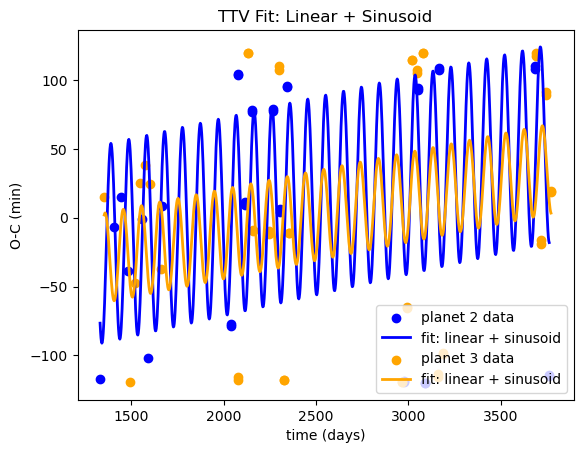

In [148]:
# Plot data and fit
plt.scatter(tc_chi_2, ttv_1_minutes, c='blue',label='planet 2 data')
plt.plot(t_fit, ttv_fit, color='blue', label='fit: linear + sinusoid', linewidth=2)

# Plot data and fit
plt.scatter(tc_chi_3, ttv_2_minutes,c='orange', label='planet 3 data')
plt.plot(t_fit_2, ttv_fit_2, color='orange', label='fit: linear + sinusoid', linewidth=2)
plt.title('TTV Fit: Linear + Sinusoid')
plt.xlabel('time (days)')
plt.ylabel('O-C (min)')
plt.legend()
plt.show()